# BI Skills Demonstration

In this notebook, I will demonstrate the core Business Intelligence skills outlined in the job description. This initial demonstration will be conducted in a local environment, with plans to migrate components to a cloud environment for scalability and automation in the future.

## Project Overview

1. **Data Acquisition and Exploration**
   - Load the Titanic dataset and store it in a specified location.
   - Perform basic Exploratory Data Analysis (EDA) to understand the dataset and identify key insights.

2. **Requirements Analysis and Definition**
   - Treat this dataset as the first batch.
   - Anticipate the arrival of additional passenger data in the future, necessitating ongoing processing.
   - Define the requirement to predict whether a passenger survived based on the provided details.

3. **System Design**
   - Develop a data model to meet the defined requirements.

4. **ELT Pipeline Development**
   - Build an Extract, Load, Transform (ELT) pipeline for data collection, cleaning, and processing.

5. **Data Quality Assurance**
   - Implement data quality testing to ensure the accuracy and reliability of the dataset.
   - Consider integrating data quality checks as part of the ELT pipeline.

6. **Reference Data Management**
   - Establish a process for managing reference data to ensure consistency and integrity across the dataset.

By following these steps, I aim to showcase the application of BI skills in a structured manner, ultimately leading to actionable insights from the Titanic dataset.


## Titanic Dataset Analysis

The dataset contains information about the passengers who were on board the Titanic. The data includes details such as passenger ID, survival status, class, name, sex, age, number of siblings/spouses aboard, number of parents/children aboard, ticket number, fare, cabin, and port of embarkation.

### Data Source

The data is downloaded from the following URL:
[https://github.com/datasciencedojo/datasets/blob/master/titanic.csv?raw=true](https://github.com/datasciencedojo/datasets/blob/master/titanic.csv?raw=true)

### Data Overview

The dataset contains 891 rows and 12 columns. Below is a summary of the dataset:

- **PassengerId**: Unique ID for each passenger
- **Survived**: Survival status (0 = No, 1 = Yes)
- **Pclass**: Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **Name**: Name of the passenger
- **Sex**: Gender of the passenger
- **Age**: Age of the passenger
- **SibSp**: Number of siblings/spouses aboard
- **Parch**: Number of parents/children aboard
- **Ticket**: Ticket number
- **Fare**: Fare paid by the passenger
- **Cabin**: Cabin number
- **Embarked**: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

1. **Data Acquisition and Exploration**
   - Load the Titanic dataset and store it in a specified location.
   - Perform basic Exploratory Data Analysis (EDA) to understand the dataset and identify key insights.

In [95]:
import pandas as pd

# Download the data from the URL
url = 'https://github.com/datasciencedojo/datasets/blob/master/titanic.csv?raw=true'
titanic_df = pd.read_csv(url)

# Write the dataframe to a CSV file locally
titanic_df.to_csv('titanic_data.csv', index=False)

# Read the dataframe from the local CSV file
titanic_df = pd.read_csv('titanic_data.csv')

In [96]:
# Display the first few rows of the dataframe
titanic_df.head()
# Check for missing values
titanic_df.isnull().sum()
# Summary statistics for numerical columns
titanic_df.describe()
# Unique values in categorical columns
titanic_df['Embarked'].unique(), titanic_df['Sex'].unique()

(array(['S', 'C', 'Q', nan], dtype=object),
 array(['male', 'female'], dtype=object))

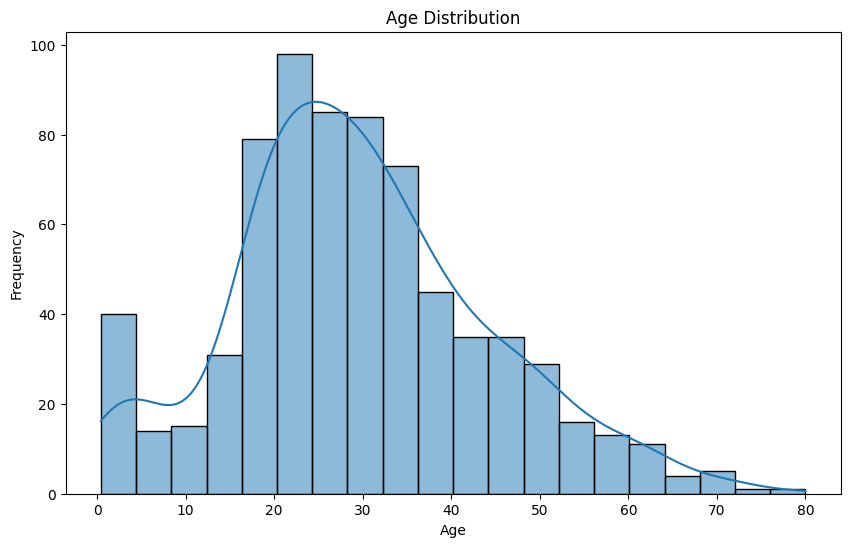

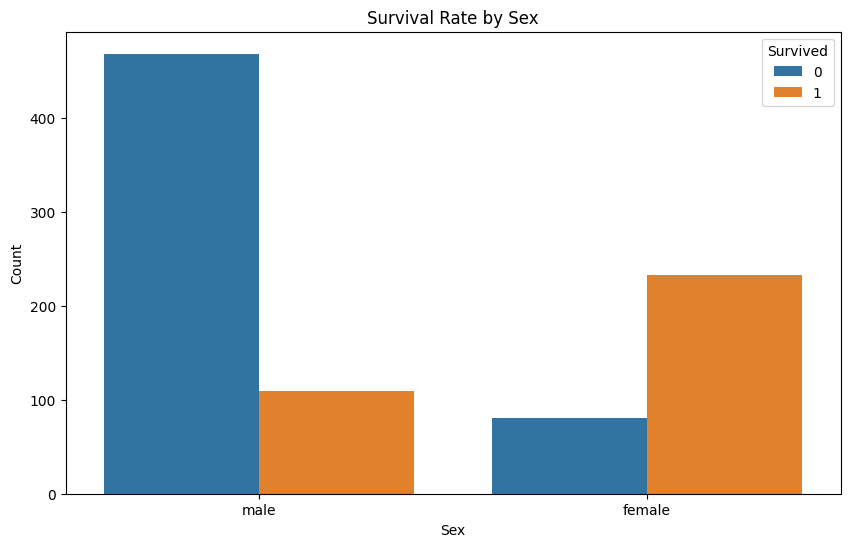

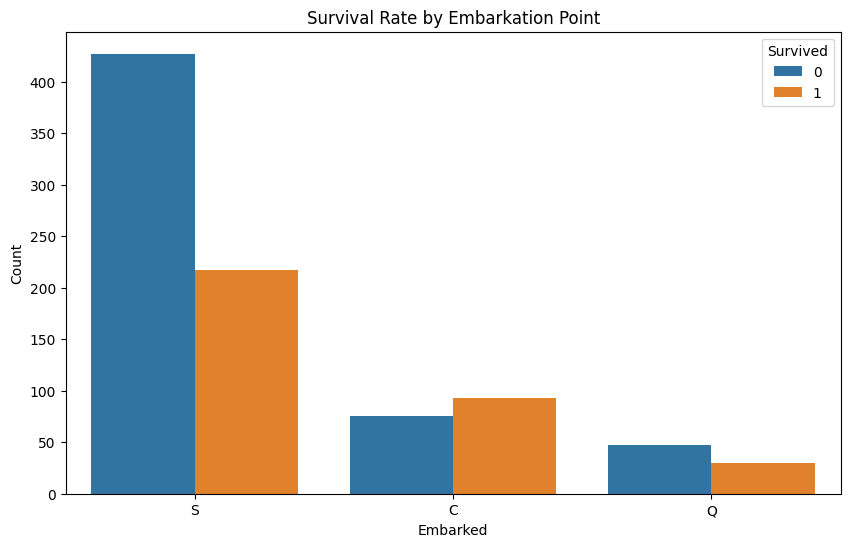

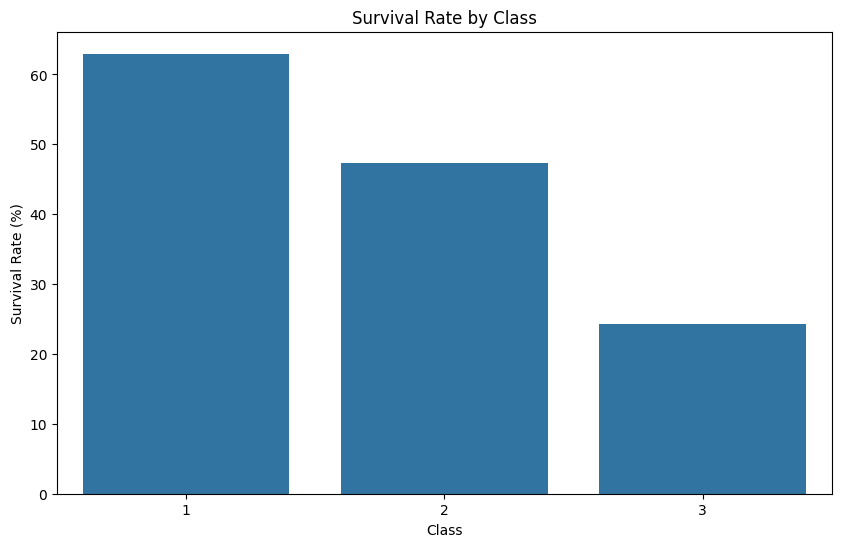

In [97]:
# Some basic Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of ages
plt.figure(figsize=(10, 6))
sns.histplot(titanic_df['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the survival rate by sex
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=titanic_df)
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot the survival rate by embarkation point
plt.figure(figsize=(10, 6))
sns.countplot(x='Embarked', hue='Survived', data=titanic_df)
plt.title('Survival Rate by Embarkation Point')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

# Plot the survival rate by Class
survival_rate_by_class = titanic_df.groupby('Pclass')['Survived'].mean() * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=survival_rate_by_class.index, y=survival_rate_by_class.values)
plt.title('Survival Rate by Class')
plt.xlabel('Class')
plt.ylabel('Survival Rate (%)')
plt.show()

In [98]:
# It makes sense to rename Parch to ParCh to keep it consistent with the SibSp column.
titanic_df = pd.read_csv('titanic_data.csv',na_filter=False)
titanic_df = titanic_df.rename(columns={'Parch': 'ParCh'})


# Ensure that the data types are correct and consistent
titanic_df['PassengerId'] = titanic_df['PassengerId'].astype(int)
titanic_df['Survived'] = titanic_df['Survived'].astype(int)
titanic_df['Pclass'] = titanic_df['Pclass'].astype(int)
titanic_df['Name'] = titanic_df['Name'].astype(str).fillna('')
titanic_df['Sex'] = titanic_df['Sex'].astype(str).fillna('')
titanic_df['Age'] = pd.to_numeric(titanic_df['Age'], errors='coerce')
titanic_df['SibSp'] = titanic_df['SibSp'].astype(int)
titanic_df['ParCh'] = titanic_df['ParCh'].astype(int)
titanic_df['Ticket'] = titanic_df['Ticket'].astype(str).fillna('')
titanic_df['Fare'] = pd.to_numeric(titanic_df['Fare'], errors='coerce')
titanic_df['Cabin'] = titanic_df['Cabin'].astype(str).fillna('')
titanic_df['Embarked'] = titanic_df['Embarked'].astype(str).fillna('')


# it makes sense to also split the name column into salutation, first name and last name columns (so we can analyze if they are related to each other and how)
titanic_df['Salutation'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic_df['LastName'] = titanic_df['Name'].apply(lambda x: x.split(',')[0].strip())
titanic_df['FirstName'] = titanic_df['Name'].apply(
    lambda x: x.split(',')[1].split('.')[1].split('(')[0].strip() if len(x.split(',')[1].split('.')) > 1 else ''
)
# Extract any additional names that are not captured as FirstName or LastName
titanic_df['AdditionalName'] = titanic_df['Name'].apply(
    lambda x: x.split('(')[1].split(')')[0].strip() if '(' in x and ')' in x else ''
)

# Create a new column FamilySize which is the sum of SibSp and ParCh plus 1 for the passenger (so we can see if people travelling together had a higher chance of survival)
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['ParCh'] + 1

In [99]:
# Looking into missing data
# Calculate the number of missing values in each column
# checking only for the original columns
nan_counts = titanic_df.iloc[:, :12].isnull().sum()
empty_string_counts = (titanic_df.iloc[:, :12] == '').sum()
total_missing_counts = nan_counts + empty_string_counts

# Calculate the percentage of missing data in each column
missing_data_percentage = (total_missing_counts / len(titanic_df)) * 100

# Combine the counts and percentages into a DataFrame for easier viewing
missing_data_report = pd.DataFrame({
    'Missing Values': total_missing_counts,
    'Percentage (%)': missing_data_percentage
})

# Display columns with missing data only
missing_data_report = missing_data_report[missing_data_report['Missing Values'] > 0]
missing_data_report



,Missing Values,Percentage (%)
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467


In [100]:
# Let's do Embarked first. We can see that there are only 2 missing values in the Embarked column.
# We can fill these missing values with the most common value in the column.
# Find the most common value in the Embarked column
most_common_embarked = titanic_df['Embarked'].mode()[0]
# Fill null or empty strings in the 'Embarked' column with the most common value
titanic_df['Embarked'] = titanic_df['Embarked'].replace('', most_common_embarked)


In [101]:
# list all unique salutations
titanic_df['Salutation'].value_counts()


Salutation
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

Mean Squared Error on Test Set: 111.54051129092828
Model MSE: 111.54
Mean Baseline MSE: 187.01
Median Baseline MSE: 185.59
              Feature  Importance
4   Salutation_Master    0.349004
5     Salutation_Miss    0.254277
1               ParCh    0.218662
0               SibSp    0.090627
7       Salutation_Mr    0.022378
11           Sex_male    0.016006
10     Salutation_Rev    0.012032
9    Salutation_Other    0.011948
2       Salutation_Dr    0.009713
8      Salutation_Mrs    0.007641
6     Salutation_Mlle    0.005734
3    Salutation_Major    0.001977


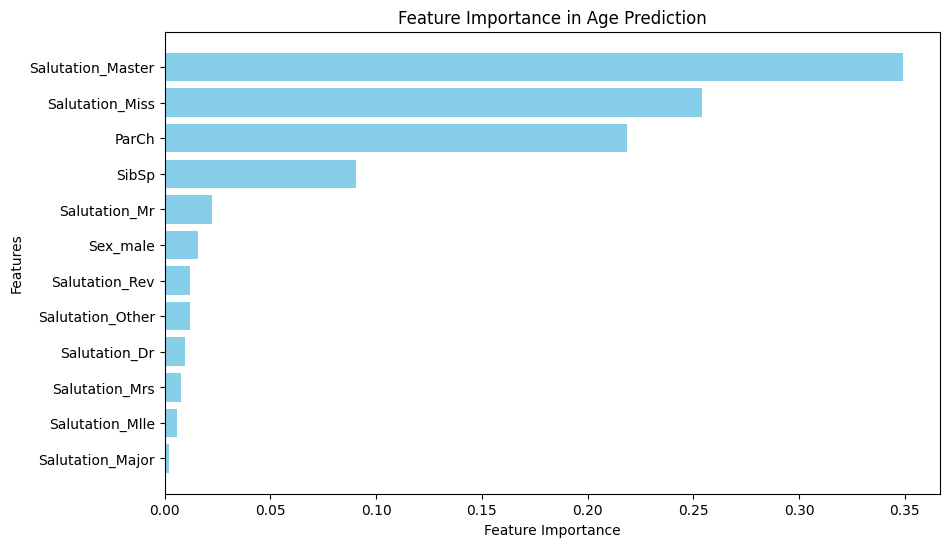

In [102]:
#Let's do Age next as it's numerical and it should be more straightforward to impute

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Copy original data into a different dataframe to preserve it
titanic_df_original = titanic_df.copy()

# Ensure categorical data is encoded; assume titanic_df has been prepared with dummies
categorical_columns =   ['Salutation','Sex']
# Given that most Salutations have few rows, we can consider consolidating them into fewer categories
# For example, we can group all Salutations with less than 2 rows into an "Other" category
salutation_counts = titanic_df['Salutation'].value_counts()
other_salutations = salutation_counts[salutation_counts < 2].index
titanic_df['Salutation'] = titanic_df['Salutation'].apply(lambda x: 'Other' if x in other_salutations else x)


titanic_df = pd.get_dummies(titanic_df, columns=categorical_columns, drop_first=True)

feature_columns = ['SibSp', 'ParCh']
# Add categorical columns by looping through columns and checking if it starts with a categorical column
for col in titanic_df.columns:
    if any(col.startswith(cat_col) for cat_col in categorical_columns):
        feature_columns.append(col)



# Separate rows with and without missing Age values
age_known = titanic_df[titanic_df['Age'].notnull()]
age_unknown = titanic_df[titanic_df['Age'].isnull()]

age_known
# Define features (X) and target (y) for the rows with known Age values
X = age_known[feature_columns]
y = age_known['Age']

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor with fewer trees for the smaller dataset
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)

# Predict missing Age values
X_unknown = age_unknown[feature_columns]
age_predictions = model.predict(X_unknown)

# Fill missing Age values in the original DataFrame
titanic_df.loc[titanic_df['Age'].isnull(), 'Age'] = age_predictions

# Evaluate the model on the test set (optional)
y_pred = model.predict(X_test)
print("Mean Squared Error on Test Set:", mean_squared_error(y_test, y_pred))

# 1. Calculate the mean and median age for the known values in the Age column
mean_age = age_known['Age'].mean()
median_age = age_known['Age'].median()

# 2. Create baseline predictions by filling missing ages with the mean and median
# Mean baseline
mean_baseline_predictions = [mean_age] * len(y_test)

# Median baseline
median_baseline_predictions = [median_age] * len(y_test)

# 3. Calculate the MSE for both the mean and median baselines
mean_baseline_mse = mean_squared_error(y_test, mean_baseline_predictions)
median_baseline_mse = mean_squared_error(y_test, median_baseline_predictions)

# 4. Compare with model's MSE
print(f"Model MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean Baseline MSE: {mean_baseline_mse:.2f}")
print(f"Median Baseline MSE: {median_baseline_mse:.2f}")


# Retrieve feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance DataFrame
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Age Prediction')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()


In [103]:
import joblib

# Assuming 'model' is your trained RandomForestRegressor and 'scaler' is your StandardScaler

# Save the RandomForestRegressor model
joblib.dump(model, 'age_model_RF.joblib')

# Save the StandardScaler
joblib.dump(scaler, 'age_scalar.joblib')

print("Random Forest model and scaler for age prediction saved successfully.")

# List all feature names in the model
feature_names = X_train.columns
print("Feature names used in the model:", feature_names.tolist())

Random Forest model and scaler for age prediction saved successfully.
Feature names used in the model: ['SibSp', 'ParCh', 'Salutation_Dr', 'Salutation_Major', 'Salutation_Master', 'Salutation_Miss', 'Salutation_Mlle', 'Salutation_Mr', 'Salutation_Mrs', 'Salutation_Other', 'Salutation_Rev', 'Sex_male']


### Model Performance Summary

- **Model MSE (113.22)**: Substantially lower than the mean (187.01) and median (185.59) baseline MSEs, indicating that the model effectively captures patterns in the data and improves prediction accuracy.
- **Conclusion**: The model performs significantly better than simple mean or median imputation, justifying its use for filling missing age values and our assumption that we could infer signifacant information by splitting the name field. I feel this could further be improved identifying parental and sibling relations. #todo


In [104]:
titanic_df_original['Age'] = titanic_df['Age']

In [105]:
# Let's predict the missing values for the Cabin column
# From searching the internet, we know that the Cabin column contains the deck information of the passengers in the format [Deck][Cabin Number]
# Putting to use all the Titanic movie rewatches, we know that the passenger class related to the deck they were on.

# Calculate the group size (number of passengers) for each ticket
titanic_df['GroupSize'] = titanic_df.groupby('Ticket')['Ticket'].transform('count')

# Calculate the per-person fare by dividing the Fare by the GroupSize for each ticket
titanic_df['PPFare'] = titanic_df['Fare'] / titanic_df['GroupSize']

# Extract the deck information from the Cabin column
titanic_df['Deck'] = titanic_df['Cabin'].apply(lambda x: x[0] if x else '')

# Populate Deck value based on other rows with the same ticket number
titanic_df['Deck'] = titanic_df.groupby('Ticket')['Deck'].transform(lambda x: x.ffill().bfill())


# Calculate the median fare for each Pclass, Deck, Embarked, and Group_Size combination
deck_fare = titanic_df[titanic_df['Deck'] != ''].groupby(['Pclass', 'Deck', 'Embarked', 'GroupSize'])['PPFare'].median().reset_index()

def estimate_deck(pclass, per_person_fare, embarked, group_size):
    # Filter by Pclass and find the closest fare within the same Embarked and Group_Size
    possible_decks = deck_fare[(deck_fare['Pclass'] == pclass) &
                               (deck_fare['Embarked'] == embarked) &
                               (deck_fare['GroupSize'] == group_size)]
    
    # Sort by absolute difference in per_person_fare to find the closest match
    closest_deck = possible_decks.iloc[(possible_decks['PPFare'] - per_person_fare).abs().argsort()[:1]]
    deck =  closest_deck['Deck'].values[0] if not closest_deck.empty else ''

    if deck == '':
        possible_decks = deck_fare[(deck_fare['Pclass'] == pclass)]
        closest_deck = possible_decks.iloc[(possible_decks['PPFare'] - per_person_fare).abs().argsort()[:1]]
        deck = closest_deck['Deck'].values[0] if not closest_deck.empty else ''

    return deck

# Apply the function to assign Deck to rows with missing Deck information (empty string or NaN)
titanic_df['Deck'] = titanic_df.apply(
    lambda row: estimate_deck(row['Pclass'], row['PPFare'], row['Embarked'], row['GroupSize']) 
    if row['Deck'] == '' or pd.isnull(row['Deck']) else row['Deck'],
    axis=1
)



# Display the updated DataFrame with inferred Deck information
print(titanic_df[['Pclass', 'Fare', 'Embarked', 'SibSp', 'ParCh', 'FamilySize', 'Deck']].head())

# There is one row in in T Deck. Looking at the data, it seems like a mistake. We can correct it by assigning it to the A Deck.
titanic_df.loc[titanic_df['Deck'] == 'T', 'Deck'] = 'A'

titanic_df_original['Deck'] = titanic_df['Deck']
titanic_df_original['PPFare'] = titanic_df['PPFare']
titanic_df_original['GroupSize'] = titanic_df['GroupSize']
# Display the updated DataFrame with numeric Deck values
print(titanic_df[['Pclass', 'Fare', 'Embarked', 'SibSp', 'ParCh', 'FamilySize', 'Deck']].head())



   Pclass     Fare Embarked  SibSp  ParCh  FamilySize Deck
0       3   7.2500        S      1      0           2    F
1       1  71.2833        C      1      0           2    C
2       3   7.9250        S      0      0           1    E
3       1  53.1000        S      1      0           2    C
4       3   8.0500        S      0      0           1    E
   Pclass     Fare Embarked  SibSp  ParCh  FamilySize Deck
0       3   7.2500        S      1      0           2    F
1       1  71.2833        C      1      0           2    C
2       3   7.9250        S      0      0           1    E
3       1  53.1000        S      1      0           2    C
4       3   8.0500        S      0      0           1    E


In [107]:
titanic_df_original['Deck'] = titanic_df['Deck']
titanic_df_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Salutation,LastName,FirstName,AdditionalName,FamilySize,Deck,PPFare,GroupSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,Mr,Braund,Owen Harris,,2,F,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley,Florence Briggs Thayer,2,C,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,Miss,Heikkinen,Laina,,1,E,7.9250,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath,Lily May Peel,2,C,26.5500,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,Mr,Allen,William Henry,,1,E,8.0500,1


In [48]:
# Below Binning attempts reduced the accuracy of the models across the board. So, I am not using them.


# plt.figure(figsize=(14, 6))

# # Age distribution
# plt.subplot(1, 2, 1)
# sns.histplot(titanic_df['Age'].dropna(), kde=True, bins=30)
# plt.title('Age Distribution')
# plt.xlabel('Age')
# plt.ylabel('Frequency')

# # Annotate each bar with the count and x-axis value
# for p in plt.gca().patches:
#     plt.gca().annotate(f'{p.get_height():.0f}\n({p.get_x():.0f})', (p.get_x() + p.get_width() / 2., p.get_height()), 
#                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# # PPFare distribution ignoring outliers
# plt.subplot(1, 2, 2)
# ppfare_without_outliers = titanic_df[titanic_df['PPFare'] < titanic_df['PPFare'].quantile(0.95)]
# sns.histplot(ppfare_without_outliers, x='PPFare', hue='Pclass', multiple='stack', kde=True, bins=30)
# plt.title('Per-Person Fare Distribution (Without Outliers)')
# plt.xlabel('PPFare')
# plt.ylabel('Frequency')

# # Annotate each bar with the x-axis value for PPFare distribution
# for p in plt.gca().patches:
#     plt.gca().annotate(f'{p.get_x():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
#                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# # for p in plt.gca().patches:
# #     plt.gca().annotate(f'{p.get_height():.0f}\n({p.get_x():.2f})', (p.get_x() + p.get_width() / 2., p.get_height()), 
# #                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# plt.tight_layout()
# plt.show()

# # Define the bins and labels
# bins = [0, 18, 40, 90]
# labels = ['Children', 'Adults', 'Old']

# # Create a new column 'AgeGroup' with the binned age values
# titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=bins, labels=labels, right=False)

# # Display the first few rows to verify the new column
# titanic_df[['Age', 'AgeGroup']].head()

# # Define the bins and labels for PPFare
# fare_bins = [0, 9, 24, float('inf')]
# fare_labels = ['Low', 'Medium', 'High']

# # Create a new column 'FareGroup' with the binned PPFare values
# titanic_df['FareGroup'] = pd.cut(titanic_df['PPFare'], bins=fare_bins, labels=fare_labels, right=False)

# # Display the first few rows to verify the new column
# titanic_df[['PPFare', 'FareGroup']].head()


In [49]:
# Filter rows where Fare is 0
fare_zero_rows = titanic_df_original[titanic_df['Fare'] == 0]

# Display the filtered rows
fare_zero_rows.sort_values(by='Pclass')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Salutation,LastName,FirstName,AdditionalName,FamilySize,Deck
263,264,0,1,"Harrison, Mr. William",male,40.00000,0,0,112059,0.0,B94,S,Mr,Harrison,William,,1,B
815,816,0,1,"Fry, Mr. Richard",male,33.05588,0,0,112058,0.0,B102,S,Mr,Fry,Richard,,1,B
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.00000,0,0,19972,0.0,,S,Jonkheer,Reuchlin,John George,,1,B
633,634,0,1,"Parr, Mr. William Henry Marsh",male,33.05588,0,0,112052,0.0,,S,Mr,Parr,William Henry Marsh,,1,B
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.00000,0,0,112050,0.0,A36,S,Mr,Andrews,Thomas Jr,,1,A
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,33.05588,0,0,239853,0.0,,S,Mr,Parkes,"Francis ""Frank""",,1,F
466,467,0,2,"Campbell, Mr. William",male,33.05588,0,0,239853,0.0,,S,Mr,Campbell,William,,1,F
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,33.05588,0,0,239853,0.0,,S,Mr,Cunningham,Alfred Fleming,,1,F
674,675,0,2,"Watson, Mr. Ennis Hastings",male,33.05588,0,0,239856,0.0,,S,Mr,Watson,Ennis Hastings,,1,F
732,733,0,2,"Knight, Mr. Robert J",male,33.05588,0,0,239855,0.0,,S,Mr,Knight,Robert J,,1,F


### Data Cleaning Summary

We have successfully populated all the missing values in the Titanic dataset. This includes imputing missing values for the `Age`, `Embarked`, and `Cabin` columns using various techniques such as mode imputation, RandomForestRegressor, and domain knowledge.

In [75]:
titanic_df_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Salutation,LastName,FirstName,AdditionalName,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,Mr,Braund,Owen Harris,,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley,Florence Briggs Thayer,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,Miss,Heikkinen,Laina,,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath,Lily May Peel,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,Mr,Allen,William Henry,,1


### Comparing Models for the prediction program


Let's start looking into predictions.
Looking at the [scikit-learn algorithm cheat-sheet](https://scikit-learn.org/1.3/tutorial/machine_learning_map/), we want to try the following:

- Logistic Regression
- Linear SVC
- K-Neighbors Classifier
- Random Forest Classifier
- Gradient Boosting Classifier
- SVM with RBF Kernel
- AdaBoost Classifier
- Naive Bayes

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# Assuming 'titanic_df' is your DataFrame and 'Survived' is the target variable

# Step 1: Prepare features (X) and target (y)
X = pd.get_dummies(titanic_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'LastName', 'FirstName', 'AdditionalName'], axis=1), drop_first=True)
y = titanic_df['Survived']

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Standardize the data (important for SVM and KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVC': SVC(kernel='linear', random_state=42),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'SVM with RBF Kernel': SVC(kernel='rbf', random_state=42),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Step 5: Train and evaluate each model
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the result
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.4f}")

# Step 6: Display a summary of results
print("\nModel Comparison:")
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for model_name, accuracy in sorted_results:
    print(f"{model_name}: {accuracy:.4f}")


Logistic Regression Accuracy: 0.7933
Linear SVC Accuracy: 0.8212
K-Neighbors Classifier Accuracy: 0.8045
Random Forest Classifier Accuracy: 0.8380
Gradient Boosting Classifier Accuracy: 0.8380
SVM with RBF Kernel Accuracy: 0.8045
AdaBoost Classifier Accuracy: 0.7933
Naive Bayes Accuracy: 0.7709

Model Comparison:
Random Forest Classifier: 0.8380
Gradient Boosting Classifier: 0.8380
Linear SVC: 0.8212
K-Neighbors Classifier: 0.8045
SVM with RBF Kernel: 0.8045
Logistic Regression: 0.7933
AdaBoost Classifier: 0.7933
Naive Bayes: 0.7709


In [51]:
# Below is an attempt to improve the accuracy of the model by dropping some features for the Random Forest Classifier.
# As the accuracy dropped from 0.8380 to 0.8156, we will not proceed with this approach.


# # Let's proceed with the Random Forest Classifier, which had the highest accuracy.
# # Let's see what features the model found most important and drop the least important ones.
# # Display the feature importances
# RandomForestClassifier = models['Random Forest Classifier']
# importances = RandomForestClassifier.feature_importances_
# importance_df = pd.DataFrame({'Feature': X.columns , 'Importance': importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print(importance_df)

# # Drop features with importance less than 0.02
# important_features = importance_df[importance_df['Importance'] >= 0.02]['Feature']
# X_important = X[important_features]

# # Split the data again with the important features
# X_train_important, X_test_important, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# # Train the Random Forest Classifier on the important features
# final_model_important = RandomForestClassifier.fit(X_train_important, y_train)

# # Make predictions on the test set
# final_predictions_important = final_model_important.predict(X_test_important)

# # Calculate accuracy
# accuracy_important = accuracy_score(y_test, final_predictions_important)
# print(f"Accuracy with important features: {accuracy_important:.4f}")


### Training the Final Model

We have trained the `RandomForestClassifier` on the entire dataset to prepare it for predicting future incoming data. This model has been saved along with the scaler for deployment purposes. The trained model can now be used to make predictions on new passenger data, ensuring that our system is ready for ongoing processing as new batches of data arrive.


In [111]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Prepare the data
# Drop non-feature columns, and one-hot encode categorical features
X = pd.get_dummies(titanic_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'LastName', 'FirstName', 'AdditionalName'], axis=1), drop_first=True)
y = titanic_df['Survived']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 2: Initialize and train the model on the full dataset
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X, y)

# Step 3: Save the trained model and scaler for deployment
joblib.dump(best_model, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Model and scaler saved successfully.")

# List all feature names in the model
feature_names = pd.get_dummies(titanic_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'LastName', 'FirstName', 'AdditionalName'], axis=1), drop_first=True).columns
print("Feature names used in the model:", feature_names.tolist())



Model and scaler saved successfully.
Feature names used in the model: ['Pclass', 'Age', 'SibSp', 'ParCh', 'Fare', 'FamilySize', 'Salutation_Dr', 'Salutation_Major', 'Salutation_Master', 'Salutation_Miss', 'Salutation_Mlle', 'Salutation_Mr', 'Salutation_Mrs', 'Salutation_Other', 'Salutation_Rev', 'Sex_male', 'GroupSize', 'PPFare', 'Embarked_Q', 'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G']
